# Assignment 2 - Classification Problem
### <i>Tausif S</i>

<br>
## 0. Introduction
The goal for this assignment is to train, validate, and tune multiple classifiers, in order to develop the best model to predict an individual's income bracket, based on a set of observations of the individual in question. The dataset used in this assignment is comprised of census data from the United States.

##### _Importing packages used._
For this assignment, the following packages are used:
* Numpy
* Matplotlib
* Pandas
* Scikit-learn

In [2]:
# To stop printing warnings related to Matplotlib building its font cache.
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To view plots inline with Jupyter Notebooks.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

<br>
## 1. Data Cleaning
##### _Importing and cleaning data._
The first task is to prepare the datsets for analysis. There are two main datasets used, which are given in the `income-training.csv` and `income-testing.csv` files. Each individual is given 14 observation features, and a 1 of 3 classes representing their income bracket. The income bracket's are split into  the following classes: &lt;50K, 50-100K, and &gt;100K.

In order to prepare the datasets, missing values within the datasets must be filled in, and the datasets need to become numerical.

### 1.1 Importing Data Sets
First, the `income-training` and `income-testing` datasets are imported using the `read_csv` function from `pandas`.

In [3]:
# Importing datasets.
income_train = pd.read_csv('/resources/data/income-training.csv')
income_test = pd.read_csv('/resources/data/income-testing.csv')

In [4]:
# Previewing the training dataset.
income_train.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,State-gov,179151,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<50K
1,28,Private,68021,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,30,United-States,<50K
2,24,Private,233499,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,50-100K
3,32,Self-emp-not-inc,168782,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32,United-States,<50K
4,55,Self-emp-not-inc,105582,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,2228,0,50,United-States,<50K


In [5]:
# Previewing the testing dataset.
income_test.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,57,Self-emp-not-inc,152030,Some-college,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,25,United-States,50-100K
1,35,Private,341643,Bachelors,13,Never-married,Other-service,Other-relative,White,Male,0,0,50,United-States,<50K
2,26,Private,40915,Bachelors,13,Never-married,Other-service,Not-in-family,White,Female,0,0,25,United-States,<50K
3,27,Federal-gov,257124,Bachelors,13,Never-married,Transport-moving,Other-relative,White,Male,0,0,35,United-States,<50K
4,21,Private,256278,HS-grad,9,Never-married,Other-service,Other-relative,Other,Female,0,0,35,El-Salvador,<50K


### 1.2 Cleaning Datasets
In order to clean the datasets, we define the `clean` function, which takes in the raw $M \times 15$ `panda` dataframe, and returns a cleaned numerical dataframe.

The `clean` function checks each feature column as to whether it's an object or not. If the feature is an object, it's perceived to be a categorical feature, and thus the column type is changed to a category. Next, it was decided that empty values for these categorical features would be filled in with the feature's mode. Finally, the categorical features are encoded to numerical values using the pandas `cat.codes` function, which assigns an integer value to each unique category alphanumerically. All non-object features are perceived to be continous, and thus the missing values are filled with the feature's mean.

In [6]:
# Function for cleaning and converting to a numerical dataframe.
def clean(raw_df):
    """
    Takes in the raw dataframe, and returns a cleaned numerical dataframe.
    Fills empty continuous features with its mean and empty categorical
    features with the feature's mode.
    
    Input:
        raw_df   : Raw M x 15 panda dataframe.
    
    Output:
        clean_df : Cleaned numerical M x 15 panda dataframe.
    """
    
    # Creating a copy of the original dataframe.
    clean_df = raw_df.copy()
    
    # Running through each feature of the dataframe.
    for i in range(0, clean_df.shape[1]):
        # Checking to see if the feature is non-numerical, i.e. a categorical feature. 
        if(clean_df.iloc[:, i].dtypes == 'object'):
            # Converting object dtype to category.
            clean_df.iloc[:, i] = clean_df.iloc[:, i].astype('category')
            # Filling empty values with the feature's mode. 
            clean_df.iloc[:, i] = clean_df.iloc[:, i].fillna(clean_df.iloc[:, i].mode()[0])
            # Encoding to numerical values.
            clean_df.iloc[:, i] = clean_df.iloc[:, i].cat.codes
        else:
            # Filling empty numerical feature values with its mean. 
            clean_df.iloc[:, i] = clean_df.iloc[:, i].fillna(round(income_train.iloc[:, i].mean()))
    
    return clean_df

Here, we apply the `clean` function with the training and testing datasets. The datasets are also split into seperate features and class datasets for future use.

In [7]:
# Cleaning the training and test sets.
cleaned_train = clean(income_train)
cleaned_test = clean(income_test)

# Splitting data frame to x and y components.
cleaned_train_x = cleaned_train[cleaned_train.columns[0:14]]
cleaned_train_y = cleaned_train[cleaned_train.columns[14]]
cleaned_test_x = cleaned_test[cleaned_test.columns[0:14]]
cleaned_test_y = cleaned_test[cleaned_test.columns[14]]

In [8]:
# Previewing cleaned training set.
cleaned_train.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,6,179151,15,10,2,4,0,4,1,0,0,40,38,1
1,28,3,68021,15,10,4,7,1,4,0,0,0,30,38,1
2,24,3,233499,15,10,2,13,0,4,1,0,0,40,38,0
3,32,5,168782,6,5,2,2,0,4,1,0,0,32,38,1
4,55,5,105582,12,14,2,11,0,4,1,2228,0,50,38,1


In [9]:
# Previewing cleaned test set.
cleaned_test.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,57,5,152030,15,10,2,11,5,4,0,0,0,25,37,0
1,35,3,341643,9,13,4,7,2,4,1,0,0,50,37,1
2,26,3,40915,9,13,4,7,1,4,0,0,0,25,37,1
3,27,0,257124,9,13,4,13,2,4,1,0,0,35,37,1
4,21,3,256278,11,9,4,7,2,3,0,0,0,35,7,1


In [10]:
# Previewing the training features dataset.
cleaned_test_x.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry
0,57,5,152030,15,10,2,11,5,4,0,0,0,25,37
1,35,3,341643,9,13,4,7,2,4,1,0,0,50,37
2,26,3,40915,9,13,4,7,1,4,0,0,0,25,37
3,27,0,257124,9,13,4,13,2,4,1,0,0,35,37
4,21,3,256278,11,9,4,7,2,3,0,0,0,35,7


<br>
## 2. Exploratory Analysis
##### _Understanding the data visually._
Before performing any analyses, it's a good idea to visualize what's going on in the first place. Thus, general raw data trends, and feature importance will be analyzed in this section.

### 2.1 Data Trends
Here, we're splitting up the original training set to be able to visualize the differences of income level depending on the following feature's categories: Education, WorkClass, and Sex. Each feature is given its own income bracket matrix, given by $M \times N$, where $M$ is the number of income brackets, and $N$ is the number of categories in the features.

The reason for choosing the features chosen for visual analyses, is based off a couple hypotheses revolving on common ideas in today's western society. These hypotheses include: higher education opens doors for higher income, private companies pay more than public offices, and an individual's gender affects their over all income.  

In [11]:
# Setting up the titles for income brackets.
inc_titles = np.asarray(income_train['IncomeBracket'].unique())

# Setting up the titles and empty zero matrix for each feature's income brackets.
edu_titles = np.asarray(income_train['Education'].unique())
edu_incbrk = np.zeros((3, len(edu_titles)))

wrk_titles = np.asarray(income_train['WorkClass'].unique())
wrk_incbrk = np.zeros((3, len(wrk_titles)))

sex_titles = np.asarray(income_train['Sex'].unique())
sex_incbrk = np.zeros((3, len(sex_titles)))

# Parsing the dataset into the relevant sections of the sorted matrix.
for i in range(0, len(inc_titles)):
    for j in range(0, len(edu_titles)):
        edu_incbrk[i, j] = income_train[income_train.Education == edu_titles[j]].IncomeBracket[income_train.IncomeBracket == inc_titles[i]].size
    for j in range(0, len(wrk_titles)):
        wrk_incbrk[i, j] = income_train[income_train.WorkClass == wrk_titles[j]].IncomeBracket[income_train.IncomeBracket == inc_titles[i]].size
    for j in range(0, len(sex_titles)):
        sex_incbrk[i, j] = income_train[income_train.Sex == sex_titles[j]].IncomeBracket[income_train.IncomeBracket == inc_titles[i]].size

With the data sorted for each feature in question, we can now graph it out to get a better understanding of what what's going on. Below is the `feature_plotter` function, which takes in the data prepared earlier and plots it accordingly.

In [12]:
def feature_plotter(feature_titles, incbrk, plot_title):
    """
    Takes feature data and plots it onto a bar charts for distribution visualization.
    
    Input:
        feature_titles : 1 x N numpy array of feature category titles.
        incbrck        : 3 x N numpy array of income breakdown.
        plot_title     : String value for plot title.
    """
    
    # Plotting the income bracket distribution for the given feature.
    plt.subplot(1, 2, 1)
    y_pos = np.arange(len(feature_titles))
    
    p1 = plt.bar(y_pos, incbrk[0, :], color = '#EA6D6A', align = 'center')
    p2 = plt.bar(y_pos, incbrk[1, :], color = '#6495ED', align = 'center', bottom = incbrk[0, :])
    p3 = plt.bar(y_pos, incbrk[2, :], color = '#52BE80', align = 'center', bottom = (incbrk[0, :] + incbrk[1, :]))
    
    plt.xticks(y_pos, feature_titles, fontsize = 10, rotation = 80)
    plt.ylabel('Number of Individuals')
    plt.legend((p1[0], p2[0], p3[0]), ('<50K', '50-100K', '>100K'), bbox_to_anchor=(0.5, 1.06), loc = 'center', ncol = 3)
    
    # Plotting the income bracket percentage breakdown for the given feature.
    plt.subplot(1, 2, 2)
    totals = incbrk.sum(axis = 0)
    incbrk_per = np.asarray(incbrk)
    for i in range(0, 3):
        incbrk_per[i, :] = 100*(incbrk_per[i, :]/totals)
    
    p4 = plt.bar(y_pos, incbrk_per[0, :], color = '#EA6D6A', align = 'center')
    p5 = plt.bar(y_pos, incbrk_per[1, :], color = '#6495ED', align = 'center', bottom = incbrk_per[0, :])
    p6 = plt.bar(y_pos, incbrk_per[2, :], color = '#52BE80', align = 'center', bottom = (incbrk_per[0, :] + incbrk_per[1, :]))
    
    plt.xticks(y_pos, feature_titles, fontsize = 10, rotation = 80)
    plt.ylabel('Percentage of Individuals (%)')
    plt.legend((p4[0], p5[0], p6[0]), ('<50K', '50-100K', '>100K'), bbox_to_anchor=(0.5, 1.06), loc = 'center', ncol = 3)
    
    plt.suptitle(plot_title, fontsize = 14, fontweight = 'bold', y = 1.05)
    plt.show()

The figure below shows the income break down for the education feature in terms of raw individuals and category percentage, on the left and right respectively. It seems that the majority of individuals in the sample size for the training set are high school graduates, as seen on the left plot. It's also interesting to note that the 50-100K group is at its highest for individuals with a bachelors degree in terms of raw individuals. The amount of individuals pursuing further higher education beyond a bachelors degree diminishes extensively, however, the percentage of higher income brackets seems to increase thoroughly as seen on the right plot. This makes sense, as it's very common for a post secondary institution to have less graduate students than undergraduate, and still somewhat follows the hypothesis of higher education leading to higher income.

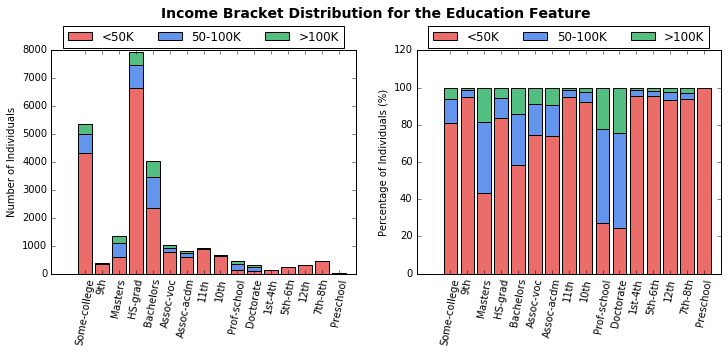

In [13]:
feature_plotter(np.copy(edu_titles), np.copy(edu_incbrk), 'Income Bracket Distribution for the Education Feature')

The next figure below shows the income break down for the work class feature in terms of raw individuals and category percentage, on the left and right respectively. It's clear to see that the majority of people work for private companies since there are usually more private jobs avaialable compared to government related jobs, which tend to be more limited, while self employed careers can be thought of as _out-of-the-norm_ for the mass population. However, the greatest chance for attaining higher income seems to be through self-employment.

Note that the figure below has a `nan` column. This is because we are using the original dataset to produce the plots in order to preserve categorical titles.

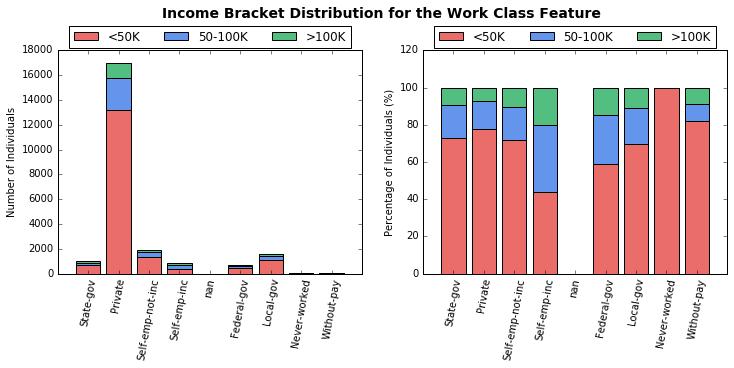

In [14]:
feature_plotter(np.copy(wrk_titles), np.copy(wrk_incbrk), 'Income Bracket Distribution for the Work Class Feature')

The final figure below shows the income break down for the sex feature in terms of raw individuals and category percentage, on the left and right respectively. Right off the bat, it's clear to see that the sample size for the training set has more male individuals than female, as seen on the left plot. Looking at the percentage breakdown on the right, it seems that the income break down is disproportionate when comparing genders and higher income rates. However, it would be more useful to compare gender with additional features, such as type of education or occupation, since statistically speaking, post secondary institutions tend to have disproportionate gender ratios in high paying fields such as the STEM majors. 

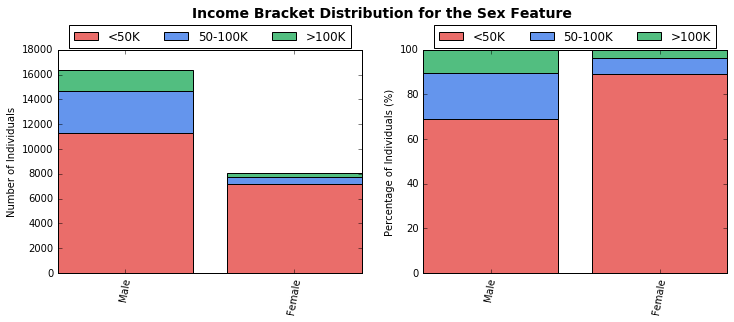

In [15]:
feature_plotter(np.copy(sex_titles), np.copy(sex_incbrk), 'Income Bracket Distribution for the Sex Feature')

### 2.2 Feature Importance
Visualizing feature importance is also an important step in classifier development, since it can allow us to see how relevant certain features are to its class. The first method of visualizing feature importance is through the principal components analysis (PCA).

PCA is essentially a dimmensional reduction tool that can help us visualize higher order $n$ dimmensional data through its covariances. PCA will take $n$ dimmensional data, and reduce it to a smaller dimmension by applying an orthogonal transformation, and finding the covariances of the different dimmensions in order to make a new, reduced set of values. These new values are both linear and uncorrelated. These new sets of values are called the principal components. It can be thought of as finding the major covariance axes directions, and projecting it onto a lower dimmensional space.

Here, we're defining the `PCA_plotter` function which applys PCA on the dataset with 2 principal components, and plotting the results.

In [16]:
def PCA_plotter(set_x, set_y, plot_title):
    """
    Takes dataset and plots its PCA plot in 2D.
    
    Input:
        set_x      : M x (N-1) panda dataframe of features.
        set_y      : M x 1 panda dataframe of classes.
        plot_title : String value for plot title.
    """
    
    # Creating numpy arrays of the panda dataframe. 
    X_train = np.asarray(set_x)
    y_train = np.asarray(set_y)
    
    # Initializing and fitting the PCA.
    PCA_ = PCA(n_components = 2)
    PCA_x = PCA_.fit(X_train).transform(X_train)

    # Plotting PCA plot.
    plt.subplot(1, 2, 1)
    labels = [0, 1, 2]
    label_names = ['50-100K', '<50K', '>100K']
    col = ['#6495ED', '#EA6D6A', '#52BE80']

    PCA_p1 = plt.scatter(PCA_x[y_train == 0, 0], PCA_x[y_train == 0, 1], label = label_names[0], color = col[0])
    PCA_p2 = plt.scatter(PCA_x[y_train == 1, 0], PCA_x[y_train == 1, 1], label = label_names[1], color = col[1])
    PCA_p3 = plt.scatter(PCA_x[y_train == 2, 0], PCA_x[y_train == 2, 1], label = label_names[2], color = col[2])
    
    plt.xticks(rotation = 80)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend((PCA_p2, PCA_p1, PCA_p3), ('<50K', '50-100K', '>100K'), bbox_to_anchor=(0.5, 1.06), loc = 'center', ncol = 3)
    
    # Finding smallest label set.
    min_i = np.amin([len(PCA_x[y_train == 0, 0]), len(PCA_x[y_train == 1, 0]), len(PCA_x[y_train == 2, 0])])//5

    # Plotting more balanced PCA plot
    plt.subplot(1, 2, 2)
    PCA_p4 = plt.scatter(PCA_x[y_train == 0, 0][0:min_i], PCA_x[y_train == 0, 1][0:min_i], label = label_names[0], color = col[0], marker = '*')
    PCA_p5 = plt.scatter(PCA_x[y_train == 1, 0][0:min_i], PCA_x[y_train == 1, 1][0:min_i], label = label_names[1], color = col[1], marker = '*')
    PCA_p6 = plt.scatter(PCA_x[y_train == 2, 0][0:min_i], PCA_x[y_train == 2, 1][0:min_i], label = label_names[2], color = col[2], marker = '*')
    
    plt.xticks(rotation = 80)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend((PCA_p5, PCA_p4, PCA_p6), ('<50K', '50-100K', '>100K'), bbox_to_anchor=(0.5, 1.06), loc = 'center', ncol = 3)
    
    plt.suptitle(plot_title, fontsize = 14, fontweight = 'bold', y = 1.05)
    plt.show()

The figure below applys the `PCA_plotter` function and develops 2 PCA plots. The plot on the left includes the PCA plot of the entire income training set, whereas the plot on the right is another PCA plot which includes a balanced amount of data points, where each class has an equal number of points. This was done since in the previous section it was discovered that there are far more individuals with and income &lt;50K, which would out shadow the remaining points in the other classes.

The figure below shows some strange relationships. It seems as if the training set suggests that there is a lot of overlap in terms of attaining a certain income bracket. Although it seems that the majority of the &lt;50K income bracket individuals are in a specific cluster with high variance in the pricipal component 1 axis and much lower variance in the principal component 2 axis. The remainder of the classes have simillar clustering properties in terms of their variance and location. There also seems to be a specific cluster of just 50-100K and &gt;100K individuals in the upper left hand side of the PCA plot with no overlap of the &lt;50K class.

The primary goal in the upcoming sections would be to decrease the high variances to make a more balanced dataset.

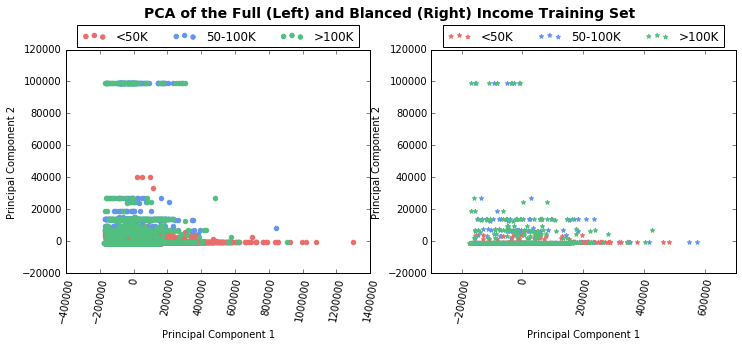

In [17]:
PCA_plotter(cleaned_train_x, cleaned_train_y, 'PCA of the Full (Left) and Blanced (Right) Income Training Set')

The next method to visualize feature importance is through a correlation plot. A correlation plot essentially measures each features correlation against each other on whether they have high positive/negative correalation, or minimal to no correlation at all. Below, we are creating the correaltion matrix using the pearson correlation coefficient method, and plotting onto a correlation plot.

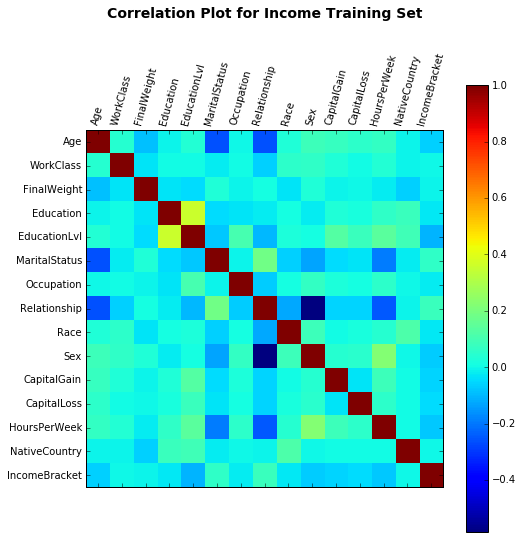

In [18]:
# Resetting plot size. 
plt.rcParams['figure.figsize'] = (12, 8)

# Creating the correlation matrix. Uses the pearson correlation coefficients.
corr_matrix = cleaned_train.copy()
corr_matrix = corr_matrix.corr()

# Plotting the correlation plot.
plt.matshow(np.asarray(corr_matrix))
fea_titles = cleaned_train.columns[0:15]
cor_y_pos = np.arange(len(fea_titles))

plt.xticks(cor_y_pos, fea_titles, rotation = 75)
plt.yticks(cor_y_pos, fea_titles)
plt.title('Correlation Plot for Income Training Set', fontsize = 14, fontweight = 'bold', y = 1.3)
plt.colorbar()
plt.show()

The figure above shows the correlation plot of the full income training set. The goal in determining feature importance is to concentrate on co-feature pairs with 0 or low positive/negative correlations, and comparing it to the correlation to the income bracket. This is because, it would suggest that these feature pairs don't have much of an affect on each other, and if a certain feature has consistant low affective co-feature pairs, that particular feature may be irrelevant to the classification model.

The first features to note are the capital gain and loss features. These two features have very consistent correlations with their co-feature pairs. These two features act very similarly, and thus could be considered for a combined feature that includes both.

The next two features of interest are the marital status and relationship features. These two features seem to work hand-in-hand, therefore removing one or the other would be best to simplify the dataset. Dropping the marital status feature and keeping the relationship feature would be ideal, since the relationship feature is more diverse and considers non-marital replationships, whereas the marital status feature can essentially be summed up into single, married, or divorced. However, it seems both features also have very minimal correlation towards the income bracket, so it could even be considered to drop both features instead.

The hours per week feature shows some strong correlation with marital status, relationship, and some correlation with income bracket, but it doesn't show much correlation towards any of the other features. Race seems to also not have a major affect on other features, although from the dataset, it seemed that the _white_ race may have been overshadowed from the entire sample set across all three classes. Either way, in order to simplyfy the dataset, the race feature could also be dropped. The native country feature seems to also have minimal to no correlation with other co-feature pairs, including the income bracket, most likely due to the _United States_ category overshadowing the remainder. Thus, the nationality feature can also be dropped.

The education and education level features, similarly to marital status and relationship features, seem to have the same affect on other features, therefore one or the other can be dropped. Ideally, the education level feature should be dropped since we've investigated the education feature earlier, however, the education level feature seems to have stronger correlation towards the income bracket.

Overall, it seems that an individual's age, education level, sex, and hours per week tend to affect their income bracket the most. The next section will investigate deeper on whether the unimportant features, and possible new features, helps the data's variance.

<br>
## 3. Feature Selection
##### _Feature engineering and selection._

### 3.1 Feature Engineering
In this section, we need to create a feature based on the original dataset. From the previous correlation plot, it seemed as if the age didn't have a stronger impact as it could. In general, the continous nature of the age can be causing some overshadowing in certain age groups, hence a feature of categorical age brackets is developped below from the continous set, in order to simplyfy the set further. The new age brackets are the following: 0-18, 19-24, 25-30, 31-40, 41-50, 51-100.

In [19]:
# Creating age bracket feature.
# Age brackets are the following: ['0-18', '19-24', '25-30', '31-40', '41-50', '51-100']
cleaned_train['Age'] = pd.cut(cleaned_train['Age'], bins = [0, 18, 24, 30, 40, 50, 100], labels = [0, 1, 2, 3, 4, 5])
cleaned_test['Age'] = pd.cut(cleaned_test['Age'], bins = [0, 18, 24, 30, 40, 50, 100], labels = [0, 1, 2, 3, 4, 5])

In [20]:
# Previewing the new datset.
cleaned_train.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,4,6,179151,15,10,2,4,0,4,1,0,0,40,38,1
1,2,3,68021,15,10,4,7,1,4,0,0,0,30,38,1
2,1,3,233499,15,10,2,13,0,4,1,0,0,40,38,0
3,3,5,168782,6,5,2,2,0,4,1,0,0,32,38,1
4,5,5,105582,12,14,2,11,0,4,1,2228,0,50,38,1


Earlier, we discussed how the capital gain and loss features had simillar impact on the entire set. It can be hypothesized that an individual that goes into investments would tend to have a higher income level. Therefore, instead of simply dropping the capital gain/loss features, another feature can be created on whether the individual is an investor or not. This can be a categorical feature, where 0 means no, and 1 means yes. This would mean that if an individual had a value for either capital gain, or loss, then the new feature's value would be 1. This may solve issues on extremely high values in the capital gain/loss features. 

In [21]:
# Creating investor feature.
# Investor feature follows the following realtionship: yes = 1, no = 0.
cleaned_train['Investor'] = np.where(((cleaned_train['CapitalGain'] + cleaned_train['CapitalLoss']) != 0), '1', '0')
cleaned_test['Investor'] = np.where(((cleaned_test['CapitalGain'] + cleaned_test['CapitalLoss']) != 0), '1', '0')

In [22]:
# Previewing the new datset.
cleaned_train.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket,Investor
0,4,6,179151,15,10,2,4,0,4,1,0,0,40,38,1,0
1,2,3,68021,15,10,4,7,1,4,0,0,0,30,38,1,0
2,1,3,233499,15,10,2,13,0,4,1,0,0,40,38,0,0
3,3,5,168782,6,5,2,2,0,4,1,0,0,32,38,1,0
4,5,5,105582,12,14,2,11,0,4,1,2228,0,50,38,1,1


### 3.2 Final Feature Selection
In this section, we select the features we need and drop the ones discussed in Sections 2.2 and 3.1. Therefore, the final features used are the following: `Age, EducationLvl, Occupation, Relationship, Sex, Investor, HoursPerWeek`.

In [23]:
# Extracting and copying final features into new training and test sets.
final_train = cleaned_train[['Age', 'EducationLvl', 'Occupation', 'Relationship', 'Sex', 'Investor', 'HoursPerWeek', 'IncomeBracket']].copy()
final_test = cleaned_test[['Age', 'EducationLvl', 'Occupation', 'Relationship', 'Sex', 'Investor', 'HoursPerWeek', 'IncomeBracket']].copy()

In [24]:
# Previewing final training set.
final_train.head()

,Age,EducationLvl,Occupation,Relationship,Sex,Investor,HoursPerWeek,IncomeBracket
0,4,10,4,0,1,0,40,1
1,2,10,7,1,0,0,30,1
2,1,10,13,0,1,0,40,0
3,3,5,2,0,1,0,32,1
4,5,14,11,0,1,1,50,1


In [25]:
# Previewing final test set.
final_test.head()

,Age,EducationLvl,Occupation,Relationship,Sex,Investor,HoursPerWeek,IncomeBracket
0,5,10,11,5,0,0,25,0
1,3,13,7,2,1,0,50,1
2,2,13,7,1,0,0,25,1
3,2,13,13,2,1,0,35,1
4,1,9,7,2,0,0,35,1


Below, we're splitting the features and classes apart into seperate dataframes for future model training use.

In [26]:
# Splitting the features and classes for the final training and test sets.
final_train_x = final_train[final_train.columns[0:7]]
final_train_y = final_train[final_train.columns[7]]
final_test_x = final_test[final_test.columns[0:7]]
final_test_y = final_test[final_test.columns[7]]

# Previousing the final training features set.
final_train_x.head()

,Age,EducationLvl,Occupation,Relationship,Sex,Investor,HoursPerWeek
0,4,10,4,0,1,0,40
1,2,10,7,1,0,0,30
2,1,10,13,0,1,0,40
3,3,5,2,0,1,0,32
4,5,14,11,0,1,1,50


Now that the final dataset is created, the new PCA plot should be checked to see how variance is affected. The figure below shows just that, where the plot on the left is the PCA of the full final datset, and the plot on the right is the balanced final dataset, with equal amounts of each class. It's clear to see that the new dataset has much less covariances than the initial dataset. However, the clusters of each class still over lap each other in cetain sections. This is most probably due to the wide distribution on the individuals in the &lt;50K income bracket thoughout each feature. However, with lower variances, a model can be trained to give much better results when comparing to the original dataset.  

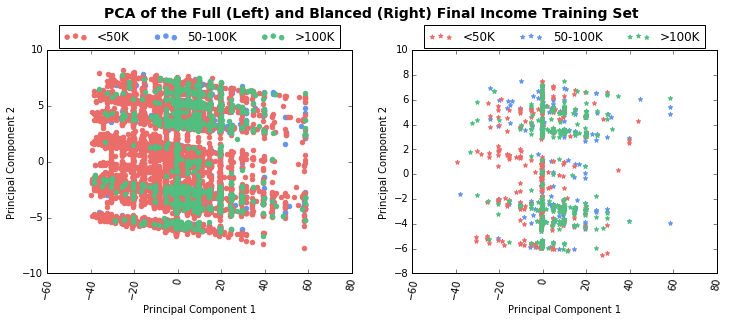

In [27]:
# Resetting plot size. 
plt.rcParams['figure.figsize'] = (12, 4)

# Plotting final dataset's PCA plot.
PCA_plotter(final_train_x, final_train_y, 'PCA of the Full (Left) and Blanced (Right) Final Income Training Set')

<br>
## 4. Model Implementation and Validation
##### _Training, validating and comparing models._
In this section, four different classification algorithms  will be implemented on the training data, while using 10-fold cross-validation. The four algorithms that were chosen are primarily ensemble methods. These algorithms include: a Bagging Classifier, Gradient Boosting, Random Forest Tree, and the Multi-Layer Perceptron Neural Network Classifier. The reason for choosing ensemble algorithms is due to their power in using multiple algorithms, in different ways, to create a much better classificatoion model.

The bagging technique, short for bootstrap aggregating, essentially works as its name suggests. The bagging classifier essentially trains multiple classifiers on random subsets of the given full dataset. The prediction is then based on the aggregate of the individual classifier's predictions, usually by voting or averaging. The benefit of this method is that it can allow a reduction in variance due to it's random nature in selecting subsets of data. This benefit leads to a con, in which the random subsets might miss out on certain relationships expressed through variance, and the features that trained on that particular section may get silenced during the aggregation portion of the algorithm.

Gradient boosting works somewhat similarly to the bagging method, except it's a collection of weak classifiers. Essentially, multiple gradient classifiers are computed on the data sequentially, where each new classifier is trained on the sections where the previous classifier failed to predict correctly on. The benfit of gradient boosting over the bagging technique is that, instead of voting/averaging the results of multiple classifiers, all the weak classifiers work together, as they now become an _expert_ in their subset of weak predictions. However, this can cause some overfitting issues, depending on how the hyperparameters are set.

Random forests is another ensemble method that essentially creates multiple decision trees on randomized subsets of data during training. This allows multiple classification predictions, where the majority of the predictions would be used as the final predicted class. This is much more efficient than using a single decision tree, since they tend to overfit very easily.

The final method considered is the multi-layer perceptron neural network. A neural network, can be thought of as a special form of an ensemble method. The basic idea of how a neural network works is it essentially stochastically optimizes multiple activation functions within each layer, for each neuron or perceptron, until the neural netowrk's loss function converges to a certain threshold. The benfits of using a neural network is that it can easily learn non-linear models. However, the cons include the stochastic nature of optimization, which won't give consistent loss/cost updates. The stochastic method must be used since loss/cost functions of hidden layers may also not be non-convex, which would also not give consistent results.

With an understanding of the pros and cons of each algortithm, the next task is to train and apply 10-fold cross validation. Below, we define the function `train_crossval_model`, which trains a given model with the given data, applies 10-fold cross validation, and then returns those accuracy values. A function is created for these steps in order to avoid repetition of the same steps. 

In [28]:
def train_crossval_model(x_train, y_train, model, model_name):
    """
    Takes in training data and a model. Trains and performs 10-fold
    cross validation. Returns an array of the 10 cross validation values.
    
    Input:
        x_train    : M x (N-1) training features.
        y_train    : M x 1 training classes.
        model      : An instance of a scikit-learn's model functions.
        model_name : String value for the model's name.
    
    Output:
        cross_val  : 1 x 10 array of cross validation scores.
    """
    print(model_name, ': Training', end = '')
    model.fit(x_train, y_train)
    print(' -> 10-Fold Cross Validating', end = '')
    cross_val = cross_val_score(model, x_train, y_train, cv = 10, scoring = 'accuracy')
    print(' -> Validation Average:', (100*cross_val.mean()), '%')
    
    return cross_val

Here, we're applying the function above to the four models discussed earlier, and displaying them in a dataframe table. Note that some of the classifiers take some time to run due to longer training requirements. The cell below may take around to 1.5 - 2 minutes to run when using the data science workbench.

In [29]:
# Transforming the data into numpy arrays.
x_train = np.asarray(final_train_x).astype('int')
y_train = np.asarray(final_train_y).astype('int')

# Setting up and cross validating each classifier.
model_BGC = BaggingClassifier()
cross_val_BGC = train_crossval_model(x_train, y_train, model_BGC, 'BGC')

model_GBC = GradientBoostingClassifier()
cross_val_GBC = train_crossval_model(x_train, y_train, model_GBC, 'GBC')

model_RFC = RandomForestClassifier()
cross_val_RFC = train_crossval_model(x_train, y_train, model_RFC, 'RFC')

model_MLP = MLPClassifier()
cross_val_MLP = train_crossval_model(x_train, y_train, model_MLP, 'MLP')

# Representing accuracy average as a panda to show the head table.
cva_avg = np.array([[100*cross_val_BGC.mean(), 100*cross_val_GBC.mean(), 100*cross_val_RFC.mean(), 100*cross_val_MLP.mean()]])
view_cva = pd.DataFrame(data = cva_avg)
view_cva.columns = ['Bagging', 'Gradient Boosting', 'Random Forest', 'MLP Neural Network']
view_cva.index = ['Cross Validation Average (%)']
view_cva.head()

BGC : Training -> 10-Fold Cross Validating -> Validation Average: 76.1926581518 %
GBC : Training -> 10-Fold Cross Validating -> Validation Average: 79.7469467727 %
RFC : Training -> 10-Fold Cross Validating -> Validation Average: 76.4057526758 %
MLP : Training -> 10-Fold Cross Validating -> Validation Average: 79.0181431077 %


,Bagging,Gradient Boosting,Random Forest,MLP Neural Network
Cross Validation Average (%),76.192658,79.746947,76.405753,79.018143


From the table above, it's clear to see that the gradient boosting classifier and the neural network out performed the remaining classifiers, while the bagging classifier gave the lowest accuracy average, with random forest very close to it. These results are very consistent which is a good sign. However, it would also be a good idea to check the individual k-fold cross validation scores, in order to truly see how consistent each model is. Therefore, we graph out the accuracy levels across each fold below.

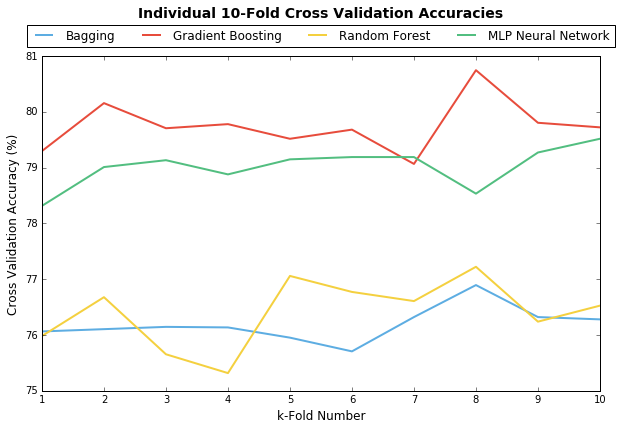

In [30]:
# Resetting plot size. 
plt.rcParams['figure.figsize'] = (10, 6)
cv_x = np.arange(10) + 1

# Plotting each individual cross validation run using 10-folds
BGC_p = plt.plot(cv_x, 100*cross_val_BGC, '-', color = '#5DADE2', linewidth = 2, label = 'Bagging')
GBC_p = plt.plot(cv_x, 100*cross_val_GBC, '-', color = '#E74C3C', linewidth = 2, label = 'Gradient Boosting')
RFC_p = plt.plot(cv_x, 100*cross_val_RFC, '-', color = '#F4D03F', linewidth = 2, label = 'Random Forest')
MLP_p = plt.plot(cv_x, 100*cross_val_MLP, '-', color = '#52BE80', linewidth = 2, label = 'MLP Neural Network')

plt.xlabel('k-Fold Number', fontsize = 12)
plt.ylabel('Cross Validation Accuracy (%)', fontsize = 12)
plt.title('Individual 10-Fold Cross Validation Accuracies', fontsize = 14, fontweight = 'bold', y = 1.1)
plt.legend(bbox_to_anchor=(0.5, 1.06), loc = 'center', ncol = 4)

plt.show()

The figure above shows the differences across each fold of the cross validation process. As discussed earlier, the bagging and random forest classifiers were consistently giving simillar results, which are shown in the graph as well. These two models, along with the neural network model, seem to have more variance in results compared to the gradient boosting results. This makes sense since, as discussed earlier, these three models have either some randomization or stochastic optimization occuring, which would result in inconsistent results.

With all of this information in mind, the next step is to further tune these models to develop the final one for testing.

<br>
## 5. Model Tuning
##### _Improving performance._
In this section, we'll further investigate the performance of the four classifiers by improving on each model's hyperparameters. The method of tuning each classifier will be to perform a grid search against 2 possible hyperparameters for each classifier and decide on the best classifier based on both accuracy and true positive rates.

Note that running the grid search cells will take several minutes when using the data science workbench. **A 10-fold cross validation is conducted only at the end of this section.** In order to speed up the process, only a 3-fold cross validation is used, for 3 possible scenarios, per 2 hyperparameters, for the grid searching sections. **Also note** that running the cells in Section 5 are **not** required in order to continue into Section 6. This is too speed up the process of this notebook. 

The cell below defines the function `perform_grid_search`, which will perform a grid search with the given model and set of hyperparameters, and the function `confusion_matrix`, which will compute and display the confusion matrix as a panda head table.

In [31]:
def perform_grid_search(hyper_grid, model, model_name):
    """
    Takes in hyperparameter grid, model and it's name. Performs grid search
    with 3-fold cross validation. Returns the grid search results.
    
    Input:
        hyper_grid : A dictionary of hyperparameters.
        model      : An instance of a scikit-learn's model functions.
        model_name : String value for the model's name.
    
    Output:
        grid       : A dictionary of grid search results.
    """
    
    # Performing grid search.
    grid = GridSearchCV(model, hyper_grid, cv = 3, scoring = 'accuracy')
    print(model_name, ': Performing Grid Search...', end = '')
    grid.fit(x_train, y_train)
    print(' -> COMPLETE')
    
    return grid

def confusion_matrix(y_true, y_pred):
    """
    Takes in training data and a model. Trains and performs 10-fold
    cross validation. Returns an array of the 10 cross validation values.
    
    Input:
        y_true    : M x 1 numpy array of true classes.
        y_pred    : M x 1 numpy array of predicted classes.
    
    Output:
        view_conf : Panda dataframe of the confusion matrix.
    """
    
    # Creating the confusion matrix.
    conf = metrics.confusion_matrix(y_train, y_pred)

    # Representing the confusion matrix as a panda to show the head table.
    view_conf = pd.DataFrame(data = conf)
    view_conf.columns = ['Predicted 0', 'Predicted 1', 'Predicted 2']
    view_conf.index = ['Ture Value 0', 'Ture Value 1', 'Ture Value 2']
    
    return view_conf

### 5.1 Tuning Bagging Classifier
The 2 hyperparameters that will be investigated are the `n_estimators`, which are the number of base estimators for the ensemble of classifieres, and the `max_samples`, which are the number of feature samples used for training each base estimator.

Below, we're defining the grid of hyperparameters and performing the grid search using the `perform_grid_search` function.

In [32]:
# Setting the possible cases of the hypeyparameters.
ne_range = np.linspace(1, 1000, num = 3).astype('int')
mx_range = np.linspace(1, 1000, num = 3).astype('int')

# Storing the possible cases into a dictionary for grid search use.
hyper_grid = dict(n_estimators = ne_range, max_samples = mx_range)

# Performing grid search on the bagging classifier.
grid_BGC = perform_grid_search(hyper_grid, model_BGC, 'BGC')

BGC : Performing Grid Search... -> COMPLETE


With possible set of hyperparameters tested agaisnt a grid search, the trends for each scenario can be seen below. It seems as if increasing `max_samples` and `n_estimators` yields better results.

In [33]:
# Lists the 3-fold cross validation accuracy scores for each scenario.
grid_BGC.grid_scores_

[mean: 0.75480, std: 0.00006, params: {'max_samples': 1, 'n_estimators': 1},
 mean: 0.75480, std: 0.00006, params: {'max_samples': 1, 'n_estimators': 500},
 mean: 0.75480, std: 0.00006, params: {'max_samples': 1, 'n_estimators': 1000},
 mean: 0.70427, std: 0.00829, params: {'max_samples': 500, 'n_estimators': 1},
 mean: 0.79526, std: 0.00264, params: {'max_samples': 500, 'n_estimators': 500},
 mean: 0.79538, std: 0.00274, params: {'max_samples': 500, 'n_estimators': 1000},
 mean: 0.71058, std: 0.01070, params: {'max_samples': 1000, 'n_estimators': 1},
 mean: 0.79235, std: 0.00427, params: {'max_samples': 1000, 'n_estimators': 500},
 mean: 0.79362, std: 0.00421, params: {'max_samples': 1000, 'n_estimators': 1000}]

The best set of hyperparameters for the bagging classifier in this case are the following:

In [34]:
# Printing the best set of hyperparameters and it's accuracy score.
print('BGC : Best Hyperparameters -', grid_BGC.best_params_, '; Score - ', 100*grid_BGC.best_score_, '%')

BGC : Best Hyperparameters - {'max_samples': 500, 'n_estimators': 1000} ; Score -  79.53810245280701 %


In order to compare with the rest of the classifiers, a confusion matrix is made below. The confusion matrix compares true and false positives agaisnt the predicted and true values. The goal when comparing all 4 classifiers would be to maximize the diagonal of the confusion matrix table below, as they are the true positives.

Below we're creating and training the final model using the best hyperparameters, and creating/displaying the confusion matrix using the `confusion_matrix` function.

In [35]:
# Creating the final model and predicting a new set of classes.
final_model_BGC = BaggingClassifier(max_samples = 1000, n_estimators = 500)
final_model_BGC.fit(x_train, y_train)
y_pred_BGC = final_model_BGC.predict(x_train)

# Creating and displaying the confusion matrix.
conf_BGC = confusion_matrix(y_train, y_pred_BGC)
conf_BGC.head()

,Predicted 0,Predicted 1,Predicted 2
Ture Value 0,1989,1997,8
Ture Value 1,720,17704,9
Ture Value 2,906,1053,35


### 5.2 Tuning Gradient Boosting Classifier
The 2 hyperparameters that will be investigated here are the `learning_rate`, which is essentially a weight coeffiecient for training that controls the contribution of each classifier, and the `n_estimators`, which is the number of boosting stages to perform, where larger numbers usually yields better results. For gradient boosting, there is usually a trade-off between the `learning_rate` and `n_estimators`.

Below, we're defining the grid of hyperparameters and performing the grid search using the `perform_grid_search` function. This will take several minutes to run when using the data science workbench.

In [36]:
# Setting the possible cases of the hypeyparameters.
lr_range = np.linspace(0.001, 1, num = 3)
ne_range = np.linspace(100, 1000, num = 3).astype('int')

# Storing the possible cases into a dictionary for grid search use.
hyper_grid = dict(learning_rate = lr_range, n_estimators = ne_range)

# Performing grid search on the gradient boosting classifier.
grid_GBC = perform_grid_search(hyper_grid, model_GBC, 'GBC')

GBC : Performing Grid Search... -> COMPLETE


With possible set of hyperparameters tested agaisnt a grid search, the trends for each scenario can be seen below. From the results it does seem that the two hyperparameters are experiencing trade-offs agaisnt each other.

In [37]:
# Lists the 3-fold cross validation accuracy scores for each scenario.
grid_GBC.grid_scores_

[mean: 0.75480, std: 0.00006, params: {'learning_rate': 0.001, 'n_estimators': 100},
 mean: 0.77368, std: 0.00128, params: {'learning_rate': 0.001, 'n_estimators': 550},
 mean: 0.78416, std: 0.00333, params: {'learning_rate': 0.001, 'n_estimators': 1000},
 mean: 0.79206, std: 0.00174, params: {'learning_rate': 0.50049999999999994, 'n_estimators': 100},
 mean: 0.78383, std: 0.00360, params: {'learning_rate': 0.50049999999999994, 'n_estimators': 550},
 mean: 0.77921, std: 0.00326, params: {'learning_rate': 0.50049999999999994, 'n_estimators': 1000},
 mean: 0.78879, std: 0.00043, params: {'learning_rate': 1.0, 'n_estimators': 100},
 mean: 0.78129, std: 0.00537, params: {'learning_rate': 1.0, 'n_estimators': 550},
 mean: 0.77970, std: 0.00711, params: {'learning_rate': 1.0, 'n_estimators': 1000}]

The best set of hyperparameters for the gradient boosting classifier in this case are the following:

In [38]:
# Printing the best set of hyperparameters and it's accuracy score.
print('GBC : Best Hyperparameters -', grid_GBC.best_params_, '; Score - ', 100*grid_GBC.best_score_, '%')

GBC : Best Hyperparameters - {'learning_rate': 0.50049999999999994, 'n_estimators': 100} ; Score -  79.2064207034929 %


Below we're creating and training the final model using the best hyperparameters, and creating/displaying the confusion matrix using the `confusion_matrix` function.

In [39]:
# Creating the final model and predicting a new set of classes.
final_model_GBC = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.5)
final_model_GBC.fit(x_train, y_train)
y_pred_GBC = final_model_GBC.predict(x_train)

# Creating and displaying the confusion matrix.
conf_GBC = confusion_matrix(y_train, y_pred_GBC)
conf_GBC.head()

,Predicted 0,Predicted 1,Predicted 2
Ture Value 0,2095,1870,29
Ture Value 1,847,17572,14
Ture Value 2,947,939,108


### 5.3 Tuning Random Forest Classifier

Only 1 main hyperparameter will be investigated here, which is the `n_estimators`, which is the number of trees in the forest in this context.

Below, we're defining the grid of hyperparameters and performing the grid search using the `perform_grid_search` function.

In [40]:
# Setting the possible cases of the hypeyparameters.
ne_range = np.linspace(10, 5000, num = 3).astype('int')

# Storing the possible cases into a dictionary for grid search use.
hyper_grid = dict(n_estimators = ne_range)

# Performing grid search on the random forest classifier.
grid_RFC = perform_grid_search(hyper_grid, model_RFC, 'RFC')

RFC : Performing Grid Search... -> COMPLETE


With possible set of hyperparameters tested agaisnt grid search, the trends for each scenario can be seen below. Although it seems that increasing the `n_estimators` hyperparameters, yields to slightly better results, the accuracy drops off beyond 5000, but was capped off in the demontration for lower run time.

In [41]:
# Lists the 3-fold cross validation accuracy scores for each scenario.
grid_RFC.grid_scores_

[mean: 0.76143, std: 0.00478, params: {'n_estimators': 10},
 mean: 0.76889, std: 0.00418, params: {'n_estimators': 2505},
 mean: 0.76950, std: 0.00537, params: {'n_estimators': 5000}]

The best set of hyperparameters for the random forest classifier in this case are the following:

In [42]:
# Printing the best set of hyperparameters and it's accuracy score.
print('RFC : Best Hyperparameters -', grid_RFC.best_params_, '; Score - ', 100*grid_RFC.best_score_, '%')

RFC : Best Hyperparameters - {'n_estimators': 5000} ; Score -  76.95016584087466 %


Below we're creating and training the final model using the best hyperparameters, and creating/displaying the confusion matrix using the `confusion_matrix` function.

Note that a different `n_estimators` is used compared to the optimal one above. This is simply because the accuracy improvement wasn't substantial enough to trade-off run time. Therefore, 2000 is being used as it seems to decrease the standard deviation across the cross validations and is better than the default 10.

In [43]:
# Creating the final model and predicting a new set of classes.
final_model_RFC = RandomForestClassifier(n_estimators = 2000)
final_model_RFC.fit(x_train, y_train)
y_pred_RFC = final_model_RFC.predict(x_train)

# Creating and displaying the confusion matrix.
conf_RFC = confusion_matrix(y_train, y_pred_RFC)
conf_RFC.head()

,Predicted 0,Predicted 1,Predicted 2
Ture Value 0,2703,1169,122
Ture Value 1,502,17859,72
Ture Value 2,536,611,847


### 5.4 Tuning Neural Network Classifier
The 2 hyperparameters that will be investigated here are the `learning_rate`, and the `max_iter`, which is the number of iterations for training. Here, the `learning_rate` is given by 3 settings, which include: constant, invscaling, and adaptive. The 3 setting essentially control whether the `learning_rate` value is constant throughout training, or grows/decays according to the situation at hand. A non-constant `learning_rate` can help with the vanishing gradient problem when optimizing the loss function. It's also typically better to have a higher `max_iter` value for training. However, too much training can cause overfitting. 

Below, we're defining the grid of hyperparameters and performing the grid search using the `perform_grid_search` function.

In [44]:
# Setting the possible cases of the hypeyparameters.
lr_type = ['constant', 'invscaling', 'adaptive']
it_range = np.linspace(200, 1000, num = 3).astype('int')

# Storing the possible cases into a dictionary for grid search use.
hyper_grid = dict(learning_rate = lr_type, max_iter = it_range)

# Performing grid search on the neural network classifier.
grid_MLP = perform_grid_search(hyper_grid, model_MLP, 'MLP')

MLP : Performing Grid Search... -> COMPLETE


With possible set of hyperparameters tested agaisnt grid search, the trends for each scenario can be seen below.

In [45]:
# Lists the 3-fold cross validation accuracy scores for each scenario.
grid_MLP.grid_scores_

[mean: 0.77528, std: 0.00825, params: {'max_iter': 200, 'learning_rate': 'constant'},
 mean: 0.78924, std: 0.00566, params: {'max_iter': 600, 'learning_rate': 'constant'},
 mean: 0.79239, std: 0.00388, params: {'max_iter': 1000, 'learning_rate': 'constant'},
 mean: 0.78244, std: 0.01440, params: {'max_iter': 200, 'learning_rate': 'invscaling'},
 mean: 0.78793, std: 0.00139, params: {'max_iter': 600, 'learning_rate': 'invscaling'},
 mean: 0.78793, std: 0.00619, params: {'max_iter': 1000, 'learning_rate': 'invscaling'},
 mean: 0.78764, std: 0.00318, params: {'max_iter': 200, 'learning_rate': 'adaptive'},
 mean: 0.78867, std: 0.00214, params: {'max_iter': 600, 'learning_rate': 'adaptive'},
 mean: 0.79354, std: 0.00250, params: {'max_iter': 1000, 'learning_rate': 'adaptive'}]

The best set of hyperparameters for the neural network classifier in this case are presented below. Note that due to the stochastic nature of this model, the best set of hyperparameters will vary slightly run to run.

In [46]:
# Printing the best set of hyperparameters and it's accuracy score.
print('MLP : Best Hyperparameters -', grid_MLP.best_params_, '; Score - ', 100*grid_MLP.best_score_, '%')

MLP : Best Hyperparameters - {'max_iter': 1000, 'learning_rate': 'adaptive'} ; Score -  79.35383481429918 %


Below we're creating and training the final model using the best hyperparameters, and creating/displaying the confusion matrix using the `confusion_matrix` function.

In [47]:
# Creating the final model and predicting a new set of classes.
final_model_MLP = MLPClassifier(max_iter = 1000, learning_rate = 'adaptive')
final_model_MLP.fit(x_train, y_train)
y_pred_MLP = final_model_MLP.predict(x_train)

# Creating and displaying the confusion matrix.
conf_MLP = confusion_matrix(y_train, y_pred_MLP)
conf_MLP.head()

,Predicted 0,Predicted 1,Predicted 2
Ture Value 0,2094,1897,3
Ture Value 1,1222,17209,2
Ture Value 2,1050,943,1


### 5.5 Final Model Selection
From the confusion matrix tables in the Section 5.1 - 5.4, many different realtionships can be seen. As mentioned earlier, the goal is to maximize the diagonal of the table, since these are the true positives. The model with the highest accuracy score is now the neural network, with gradient boosting classifier at a very close second. However, the gradient boosting model's confusion table compared to the neural network and random forest tabeles shows some strange differences. In general, the random forest and neural network models both seemed to classify more 0 and 1 classes than the gradient boosting model. However, the gradient boosting model has a balanced set of true positives across all the classes compared to the rest of the models. Furthermore, the gradient boosting and neural network model's, although have a very simillar accuracy, their confusion table's diagonals are more balanced compared to very unbalanced distributions in true positives between classes 0 and 2, for the gradient boosting and neural network respectively.

Therefore, the final model chosen is the gradient boosting classifier, since it has more balanced true positive rates across all classes, and has a simillar accuracy as the best performer, the neural net. This makes sense, as the combination of weak learners have become an expert on their on subset. The final gradient boosting model will have the hyperparameters of `n_estimators` = 100, and `learning_rate` = 0.5.

Below we're performing a final 10-fold cross validation to make sure it still has an accuracy score above 70%.

In [48]:
# Performing a final 10-fold cross validation on the final gradient boosting classifier.
final_cross_val_GBC = train_crossval_model(x_train, y_train, final_model_GBC, 'GBC')

GBC : Training -> 10-Fold Cross Validating -> Validation Average: 79.4439733842 %


<br>
## 6. Testing and Discussion
##### _Testing the tuned model._
With the final model created, the test set can finally be put to use. The cell below applys the already optimal gradient boosting classifier to produce a new set of classes using the test set. The accuracy score is also checked, using the new predicted set, and the original set of classes. 

In [49]:
# Transforming the data into numpy arrays.
x_test = np.asarray(final_test_x).astype('int')
y_test = np.asarray(final_test_y).astype('int')

try:
    # Developping the new predicted set.
    predicted_set = final_model_GBC.predict(x_test)
except:
    # If the grid search cells are not run in Section 5, model is created.
    final_model_GBC = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.5)
    final_model_GBC.fit(x_train, y_train)
    predicted_set = final_model_GBC.predict(x_test)

# Printing the predicted test set class accuracy. 
print("Test Set Accuracy:", (100*metrics.accuracy_score(y_test, predicted_set)), "%")

Test Set Accuracy: 78.6422078454 %


Thus, the **final test set accuracy is around 78%.**

In general, the test set applied on the optimal gradient boosting classifier, tends to perform very close to the training cross validation averages. In almost every run, it's within 1%. This suggests that the trained model isn't overfit or underfit, since the accuracy scores are relatively consistent.

Methods to better performance may include better feature selection or engineering. Since some of the features were modified here, the performance will vary against the raw dataset alone. However, further investigation was conducted on the original dataset and the finalized one, and the performace was consistently better with the final datasets. Further feature engineering experimentation can be looked into for better performance.

An additional method that could be further investigated is the use of equal class observations. The idea behind it that the equal amount of classes allows a model to train on an equal number of each class, thus avoiding overshadowing issues with majority classes. This was tested in the earlier stages of the assignment, however, was abondoned due to poor results. The cell below shows the performance of a smaller, balanced, class set where the resutls were consistently in the 50% - 60% range.  

In [50]:
# Finding smallest label set.
min_i = np.amin([len(x_train[y_train == 0, 0]), len(x_train[y_train == 1, 0]), len(x_train[y_train == 2, 0])])

# Class 0 small set.
x_small_class_0 = np.asarray(x_train[y_train == 0, :])[0:min_i, :]
y_small_class_0 = np.asarray(y_train[y_train == 0])[0:min_i]

# Class 1 small set.
x_small_class_1 = np.asarray(x_train[y_train == 1, :])[0:min_i, :]
y_small_class_1 = np.asarray(y_train[y_train == 1])[0:min_i]

# Class 2 small set.
x_small_class_2 = np.asarray(x_train[y_train == 2, :])[0:min_i, :]
y_small_class_2 = np.asarray(y_train[y_train == 2])[0:min_i]

# Full small set.
x_train_small = np.concatenate((x_small_class_0, x_small_class_1, x_small_class_2), axis=0)
y_train_small = np.concatenate((y_small_class_0, y_small_class_1, y_small_class_2), axis=0)

# Applying cross validation to small set.
smaller_model_GBC = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.5)
cross_val_small = train_crossval_model(x_train_small, y_train_small, smaller_model_GBC, 'GBC')

GBC : Training -> 10-Fold Cross Validating -> Validation Average: 53.6257956449 %
